<a href="https://colab.research.google.com/github/LuisDoc/Applied-Data-Analytics/blob/main/HandsOnPython_05_Entscheidungsbaum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Erstellen eines Prognosemodells für den Energieverbrauch


Dieses Notebook zeigt
- wie man mithilfe eines Entscheidungsbaums ein Vorhersagemodell für den Energieverbrauch erstellen kann
- wie man die Modell-Performance bewerten kann
- wie man die Modell-Performance optimieren kann (Hyperparameteroptimierung)

In [1]:
### Bibliotheken einbinden

## Datenanalyse
import pandas as pd
import numpy as np

## Plotten
import matplotlib.pyplot as plt
# zeige Plots in Zellen des Notebooks an
%matplotlib inline 
import seaborn as sns
# setze seaborn style defaults und Default-Wert für Plotgröße
sns.set(rc={'figure.figsize':(20, 10)}) 

## Maschinelles Lernen
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Google Drive mounten
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Aufgabe 1
Lesen Sie den Datensatz Energieverbrauch.csv ein und geben Sie sich die ersten Spalten aus.

In [3]:
data = pd.read_csv('/content/drive/My Drive/Energieverbrauch.csv')
data.head()

,Date,Consumption
0,2012-01-01,948.128
1,2012-01-02,1269.581
2,2012-01-03,1334.745
3,2012-01-04,1347.136
4,2012-01-05,1376.658


## Aufgabe 2
- Sie wollen ein Vorhersagemodell für den Energiebedarf erstellen.
- Indizieren Sie dazu zunächst das Dataframe mit dem Zeitstempel. 
- Vergessen Sie dabei nicht, das Datenformat der Spalte Date falls nötig zu ändern

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Consumption
Date,
2012-01-01,948.128
2012-01-02,1269.581
2012-01-03,1334.745
2012-01-04,1347.136
2012-01-05,1376.658


## Aufgabe 3
- Für das Vorhersagemodell wollen Sie folgende Merkmale heranziehen: 
    Jahr, Monat, Wochentag (0,1,2,3...,6 für Mo-So)
- Solche zeitlichen Merkmale können Sie ganz leicht mithilfe des Zeitstempel-Index generieren. 
- Für den Wochentag wurde das unten beispielhaft schon durchgeführt. 
- Fügen Sie auf ähnliche Weise zwei weitere Spalten mit den Merkmalen Jahr und Monat ein. Hinweis: Verwenden Sie dazu die Attribute year und month des index.
- Geben Sie sich Teile des Dataframes aus und inspizieren Sie die neu hinzugefügten Merkmale.

In [9]:
data['Weekday'] = data.index.weekday

# Das hier noch anpassen
data['Year'] = data.index.year
data['Month'] = data.index.month

## Aufgabe 4
- Weiterhin wollen Sie das Merkmal Wochenende 0/1 generieren. 
- Wie das funktioniert, sieht man in der unteren Zelle.
- Gehen Sie den Code durch und versuchen Sie zu verstehen, was passiert

In [10]:
data['Weekend'] = [0 if x < 5 else 1 for x in data.index.weekday]
#Weekend wird 0 gesetzt wenn x kleiner 5 und 1 wenn x größer 5 ist, wobei x dem weekday index entspricht

## Aufgabe 5
- Unten kommt eine Zelle mit einer Hilfsfunktion. Sie müssen die Zelle einfach nur ausführen. Die Funktion an sich müssen Sie nicht verändern. 
- Versuchen Sie zu verstehen, was passiert. Was macht die Hilfsfunktion?




Antwort: 
Die Testmenge wird aufgeteilt um Daten zum Trainieren, Validieren und Testen zu haben. Die Df Teilmengen werden in eigenen Variablen abgespeichert ( df_train, usw)

Anschließend wird der das Label mit den Werten der Spalten gesetzt.

Zuletzt werden die Merkmale aus den Daten entfernt

In [11]:
# Hilfsfunktion
def generate_sets(df): 
    
    # Spalte df auf in Trainings-, Validierungs- und Testmenge in den Anteilen 60%, 20%, 20%
    df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])        
        
    # Auswahl der Label durch Auswahl der entsprechenden Spalten                 
    y_train = df_train['Consumption']
    y_validate = df_validate['Consumption']
    y_test = df_test['Consumption']
        
    # Merkmale nicht in des Modell einbeziehen und somit die jeweiligen Spalten aus dem Datensatz entfernen
    X_train = df_train.drop(['Consumption','Year'], axis=1)
    X_validate = df_validate.drop(['Consumption','Year'], axis=1)
    X_test = df_test.drop(['Consumption','Year'], axis=1)                                                                          
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test
    

## Aufgabe 6
- Oben in der Hilfsfunktion wird das Merkmal 'Year' aus den Datensätzen entfernt und nicht in das Modell einbezogen. Warum macht das Sinn?
- Weiterhin wird aus X_train/validate/test die Spalte "Consumption" gelöscht. Wieso macht das Sinn?
- Wozu braucht man Trainings-, Validierungs- und Testmenge?

Antwort: 
1. Das Jahr des Verbrauchs ist irrelevant, im Bezug auf den Strombedarf
2. Weil der wert in den y_train/validate/test gespeichert wird
3. Die Phasen Training, Validierung und Test benötigen alle jeweils Daten.
Die Daten müssen sich aber unterscheiden, weil ein Test mit einem Datensatz keinen Sinn ergibt, wenn genau die identischen Daten auch trainiert wurden.
Daher bietet es sich an den vorhanden Datensatz für alle drei Phasen aufzuteilen und zu verwenden.  

In [12]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit der Hilfsfunktion:
X_train, y_train, X_val, y_val, X_test, y_test = generate_sets(data)

## Aufgabe 7
- Es folgt eine Hilfsfunktion zum Trainieren eines Entscheidungsbaum und der graphischen Ausgabe des trainierten Baumes.
- Auch an dieser Funktion müssen Sie nichts ändern.
- Vielleicht verstehen Sie Teile der Funktion?
- Schauen Sie sich an, wie man Funktionen zum leichteren Verständnis mittels ''' ''' kommentieren kann

In [13]:
# Hilfsfunktion 2
def train_decision_tree(X_train, y_train, min_samples_split = 2, min_samples_leaf = 1, output=False):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Split,
                                        wenn int, Mindestanzahl Samples in jedem Split
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Blatt des Entscheidungsbaumes,
                                        wenn int, Mindestanzahl Samples in jedem Blatt
    output (bool): ob eine Ausgabe erzeugt werden soll (Die Ausgabe enthält die Regeln des Entscheidungsbaumes und eine graphische 
                   Darstellung des Entscheidungsbaumes)
                   
    Outputs:
    dtr: ein auf der Trainingsmenge trainierter Entscheidungsbaum, der nachfolgend zur Prognose verwendet werden kann          
    '''

    """
    Mehrzeilige Kommentare Möglichkeit 1
    """

    '''
    Mehrzeilige Kommentare Möglichkeit 2
    '''

    
    # Spaltennamen (=Namen der Merkmale) für später speichern
    feature_names = list(X_train.columns)
    
    # Dataframes in numpy arrays konvertieren, da der Entscheidungsbaum das als Input benötigt
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #Entscheidungsbaum mit bestimmten Hyperparametern (min_samples_splkit und min_samples_leaf intialisieren)
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Entscheidungsbaum trainieren
    dtr.fit(X_train, y_train)
    
    # Optionale Ausgabe generieren
    if output:
        
        rules = export_text(dtr, feature_names = feature_names)
        print(rules)
        print('Folgende Merkmale waren verfügbar:', feature_names)
        
        with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)
    
    return dtr

### Aufgabe 8:
- Als nächstes wollen wir einen Entscheidungsbaum auf dem Trainingsdatensatz trainieren. 
- Dazu wird die Hilfsfunktion train_decision_tree herangezogen. 
- Diese enthält die Parameter min_samples_split und min_samples_leaf
- Was bedeuten diese Parameter? Versuchen Sie dies mithilfe der Dokumentation zu klären:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Was passiert wenn Sie diese Parameter verändern?
- Führen Sie die Funktion in der untenstehenden Zelle mehrfach aus und variieren Sie dabei z.B. min_samples_split zwischen 2 und 2000. Probieren Sie mindestens 10 verschiedene Werte in diesem Bereich aus und betrachten den entstehenden Entscheidungsbaum

Antwort:
1. **Was bedeuten min_samples_split und min_samples_leaf**

**min_samples_split**: Die Mindestanzahl an Samples die benötigt wird, um einen internen Knoten zu spalten. Je mehr Daten gefordert werden, desto mehr werden benötigt um eine Differenzierung zu schaffen
**min_samples_leaf**: Die Mindestanzahl an Samples die benötigt wird, für einen Blattknoten. Jeder Nachfolger eines Split Knoten muss mindestens diese Anzahl an Samples haben.

2. **Was passiert bei Veränderung ?**

Ändert man den Min_Samples_Split Parameter auf z.B. 2000, wird nur noch ein großer Knoten erzeugt, weil nicht genügend Samples vorhanden sind, um den Knoten aufzuspalten. Stellt man Min_Samples_Split z.b. auf 50, werden deutlich mehr Knoten erzeugt, weil weniger Samples pro Knoten benötigt werden, um diesen aufzuteilen.

Ändert man den Min_Samples_Leaf kann man erkennen, dass die Knoten immer mindestens die angegebene anzahl an Samples einhalten. Somit werden abhängig von der Anzahl an Samples die Knoten weiter aufgeteilt oder zusammen gehalten


|--- Weekday <= 3.50
|   |--- value: [1424.78]
|--- Weekday >  3.50
|   |--- value: [1239.69]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']


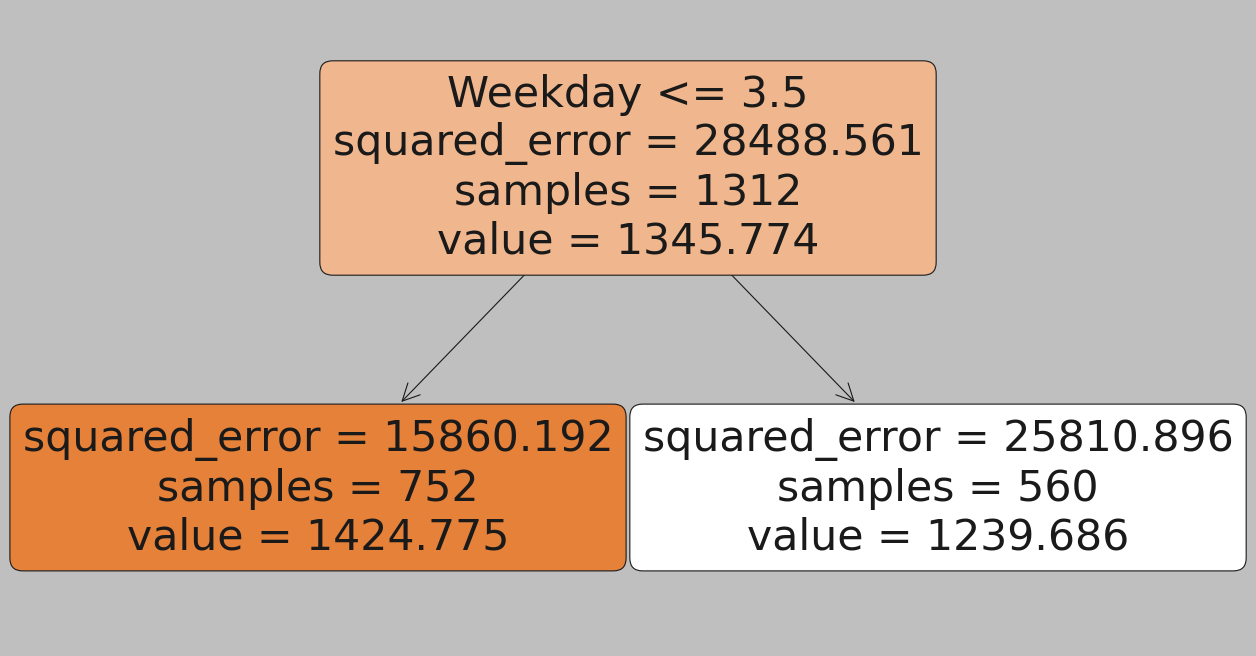

In [30]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit Hilfsfunktion generate_sets
trained_decision_tree = train_decision_tree(X_train, y_train, min_samples_split = 900, min_samples_leaf = 400, output=True)

- Es folgt eine weitere Hilfsfunktion zur Vorhersage des Energieverbrauchs mithilfe des zuvor trainierten Entscheidungsbaums
- Auch an dieser Funktion müssen Sie nichts ändern und wir sprechen sie gemeinsam durch.
- Wichtig: mit dieser Funktion kann man testen, wie gut die Vorhersage auf der Validierungsmenge funktioniert, siehe Aufgabe 8

In [31]:
# Hilfsfunktion 3
def predict_with_decision_tree(dtr, X_val, y_val, output=True):
    '''
    Hilfsfunktion zur Erstellung einer Vorhersage auf Basis eines trainierten Entscheidungsbaumes und zur Ausgabe der Gütemaße.
    
    Inputs: 
    dtr: ein zuvor auf einer Trainingsmenge trainierter Entscheidungsbaum, der zur Prognose verwendet werden kann  
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    output (bool): ob eine print-Ausgabe erzeugt werden soll (enthält Gütemaße), standardmäßig auf True.
   
    Outputs:
    y_pred (np.array): Vorhersage des Entscheidungsbaumes für die Merkmalsvektoren der Validierungsmenge   
    metrics_dict (dict): Dictionary mit den Metriken zur Bewertung der Vorhersagegüte
    '''  
    
    # Vorhersage für Validierungsmenge mit Entscheidungsbaum generieren
    y_pred = dtr.predict(X_val)
    
    ## Metriken zur Bewertung der Vorhersagegüte berechnen
    # Absoluten Fehler berechnen: Betrag der Differenz zwischen Vorhersage und den tatsächlichen Label der Validierungsmenge
    abs_errors = abs(y_pred - y_val)

    # Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae = mean_absolute_error(y_val, y_pred)
    
    # Relativen Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae_rel = mae/np.mean(y_val)
    
    # Mean Absolut Percentage Error (MAPE) berechnen
    mape = np.mean(abs_errors/y_val)
    
    # Mean Squared Error 
    mse = mean_squared_error(y_val, y_pred) 
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse) / np.mean(y_val)
    
    metrics_dict = {'mae': mae,
                    'mse': mse,
                    'mae%': mae_rel*100,
                    'mape%': mape*100,
                    'rmse%': rmse*100
                   }
    
    if output:
        print('Mittelwert der wahren Label', round(np.mean(y_val), 2))
        print('MAE', round(mae, 4))
        print('MSE', round(mse, 4))
        print('MAE%', mae_rel*100)
        print('MAPE%', mape*100)
        print('RMSE%', rmse*100)
            
    return y_pred, metrics_dict

## Aufgabe 8
- Mit dem trainierten Entscheidungsbaum (trained_decision_tree) werden im nächsten Schritt Vorhersagen für die Validierungsmenge erstellt
- Die Vorhersagen des Entscheidungsbaums werden innerhalb von Hilfsfunktion 3 mit den tatsächlichen Labeln der Validierungmenge verglichen
- Verschiedene Metriken zur Bewertung der Güte der Regression können herangezogen werden, s. Vorlesung
- Was bedeutet die einzelnen Metriken, die nach Ausführen der nächsten Zelle ausgegeben werden?
- Ist das Prognosemodell gut?


Antwort: 

**MAE (Mittlerer Absoluter Fehler) ** - Durchschnitt der absoluten Differenz zwischen prognostizierten Werten und wahren Werten. Eine MAE von 0 bedeutet, dass kein Fehler in den prognostizierten Werten vorliegt.
Ein Wert von ca. 103 ist also nicht gut.
Allerdings gibt der MAE keine Auskunft darüber, ob die Fehler groß oder klein sind.

**MAE% ** - Normierung von MAE um auf % zu kommen. Dazu wird der MAE geteilt durch den Mittelwert der erwarteten Werte. Also konkret sind 7% der Werte nicht richtig.

** MSE (Mittlerer Quadratischer Fehler)** - Der erwartete quadratische Abstand des Schätzwerts. Definiert die Qualität des Prognosemodells. Beinhaltet die Varianz als auch die Verzerrung. Je näher der Wert an 0 liegt, desto besser ist das Modell. Nicht empfohlen bei geringen Datenmengen.
Der vorliegende Wert von ca. 17916.5132 ist also nicht gut.

**RMSE% (Wurzel der mittleren Fehlerquadratsumme) ** - Gibt an wie stark eine Prognose im durchschnitt von den tatsächlichen Beobachtungswerten abwiecht. Wird berechnet auf der Quadratwurzel des durchschnittlichen Prognosefehlers.
Je größer der RMSE, desto schlechter ist dieser.
Mit einem Wert von 9% ist dieser nicht gut.

**MAPE% (Mittlerer absoluter prozentualer Fehler) ** - prozentualer Mittelwert der absoluten Differenz zwischen prognostizierten Werten und wahren Werten, geteilt durch den wahren Wert. Auch hier ist ein niedriger Wert besser.
Mit ca. 7% ist der Wert nicht gut.

**Das Prognosemodell ist nicht gut, die Abweichungen sind zu groß**

In [39]:
# Erzeuge mit dem Trainierten Entscheidungsbaum eine Vorhersage für das Validierungsset
y_pred, metrics_dict = predict_with_decision_tree(trained_decision_tree, X_val, y_val, output=True)

Mittelwert der wahren Label 1354.86
MAE 103.1369
MSE 17916.5132
MAE% 7.6123735093642955
MAPE% 7.8413635788308875
RMSE% 9.879448393200423


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## Aufgabe 9
- Wir wollen ein gute Wahl für den Hyperparameter min_samples_split treffen.
- Dafür gibt es Hilfsfunktion 4. Können Sie erkennen, was in der Hilfsfunktion passiert?
- Versuchen Sie einen Kommentar zu verfassen, der die Hilfsfunktion beschreibt.

In [40]:
# Hilfsfunktion 4
def optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%'):
    '''
    Hilfsfunktion zur Optimierung der Hyperparameter
    
    Inputs: 
    x_train: x-Werte des Trainingsdatensatzes
    y_train: y-Werte des Trainignsdatensatzes
    x_val: x-Werte des Validierungsdatensatzes
    y_val: y-Werte des Validierungsdatensatzes
    metric: Den erwarteten Metric Typ
    Outputs:
    metrics-list: 
    best_metric: Rückgabe des Optimalen Werts für die Metric 
    best_min_split: Rückgabe des optimalen Min_Samples_Split Parameter-Wertes
    
    
    ''' 
    
    # Anzahl der Beobachtungen bestimmen, funktioniert über Zeilenanzahl von X_train.
    number_of_samples = X_train.shape[0]
    
    # Noch leere Liste für Metriken erstellen, die später sukzessive gefüllt wird.
    metrics_list = []
    
    # Optimalen Wert für Metrik mit großer Zahl initialisieren
    best_metric = 100000
    
    ## Schleife zum Optimieren des Hyperparameters min_samples split
    # min_samples_split wird auf Werte zwischen 2 und int(np.floor(1/5*number_of_samples)) gesetzt und in Einserschritten erhöht.
    # Für jedes gesetzte min_samples_split wird ein Entscheidungsbaum trainiert 
    # und dessen Performance anhand der Validierungsmenge getestet
    for min_samples_split in range(2, int(np.floor(1/3*number_of_samples))):
        
        # Trainieren eines Entscheidungsbaums mit bestimmtem Wert für min_samples_split 
        decision_tree = train_decision_tree(X_train, y_train, min_samples_split = min_samples_split, output=False) #Trainiere Entscheidungsbaum mit min_samples_split
        
        # Auswerten der Performance des Entscheidungsbaums durch Einsetzen der Validierungsmenge 
        # und Vergleich der vorhergesagten Label y_pred mit den wahren Labeln y_val
        y_pred, metrics_dict = predict_with_decision_tree(decision_tree, X_val, y_val, output=False)
        metrics_list.append((min_samples_split, metrics_dict)) #Speichern der Daten in Metrics Liste
        
        # Finden des optimalen Werts für min_samples_split
        if metrics_dict[metric] <= best_metric:
            best_metric = metrics_dict[metric]
            best_min_split = min_samples_split 
            
    ## Plotten der Ergebnisse 
    # Linienplot mit (x=Werte für min_samples_split, y=Wert der ausgewählten Metrik)
    plt.figure(figsize=(20,10))
    sns.lineplot(x=[i[0] for i in metrics_list], y=[i[1][metric] for i in metrics_list])
    # Vertikale Linie bei x=best_min_split
    plt.axvline(x=best_min_split, color='k', linestyle = '--')
    # Horizontale Linie bei dazugehörigem y, sowie Legende erzeugen
    plt.axhline(y=best_metric, color='k', linestyle = '--', 
                label='Bester Wert für min_samples_split: ' + str(best_min_split) + '\n' + metric + ': ' + str(best_metric))
    plt.legend()
    
    # Ausgabe der Funktion
    return metrics_list, best_metric, best_min_split


## Aufgabe 10
- Führen Sie die obige Zelle aus, sodass die Funktion optimize_hyperparam() definiert wird.
- Wenden Sie anschließend die Funktion optimize_hyperparam() an durch ausführen der unteren Zelle und bestimmen Sie metrics_list, best_metric und best_min_split
- Wie interpretieren Sie den erzeugten Plot? Wie sollten Sie den Hyperparameter min_samples_split setzen?


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

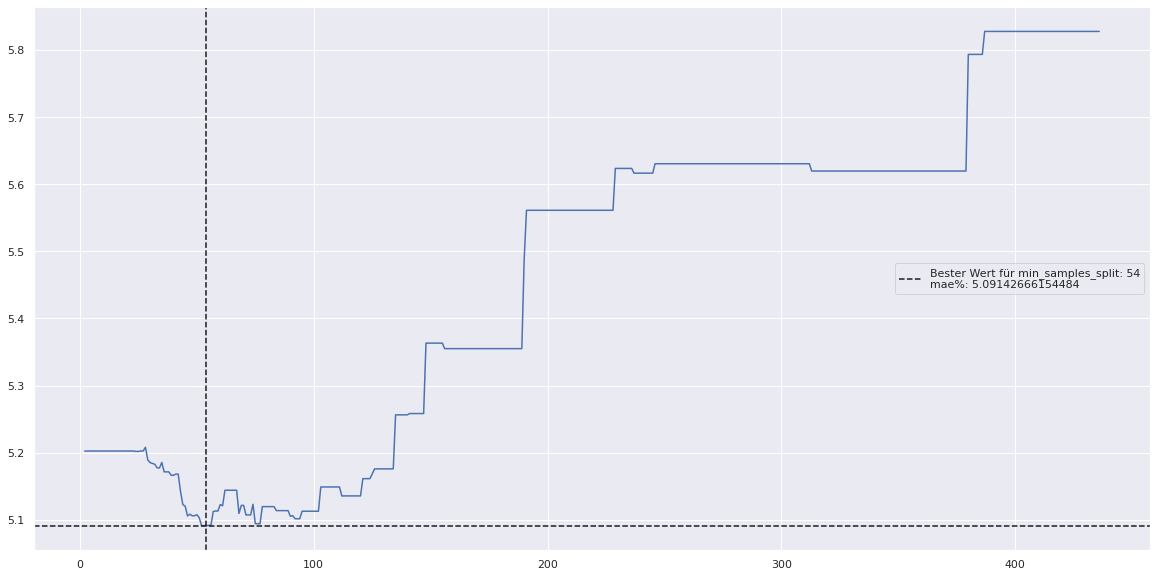

In [42]:
metrics_list, best_metric, best_min_split = optimize_hyperparam(X_train, y_train, X_val, y_val) # in die Klammer muss noch etwas rein, was?

## Aufgabe 11
- Trainieren Sie erneut einen Entscheidungsbaum und setzten Sie dabei gezielt min_samples_split auf den gefundenen optimalen Wert, indem Sie die unten stehende Funktion ausführen.
- Was sagen Sie zu dem Ergebnis?
- Wenn Sie mit einem Fehler %mae <= 7% zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten?

Antwort: 
1. **Was sagen Sie zu dem Ergebnis?**
Der MAE ist deutlich besser. Allerdings ist der Baum für den Menschen nur sehr schwer lesbar und sehr unübersichtlich

2. **Welche Werte für best_min_split könnten Sie setzen?**
Mit ca. *min_samples_split = 470* ist der Baum noch aussagekräftig aber gleichzeitig gut lesbar für den Menschen


|--- Weekday <= 4.50
|   |--- Month <= 3.50
|   |   |--- Month <= 2.50
|   |   |   |--- Weekday <= 0.50
|   |   |   |   |--- value: [1510.33]
|   |   |   |--- Weekday >  0.50
|   |   |   |   |--- Weekday <= 3.50
|   |   |   |   |   |--- Month <= 1.50
|   |   |   |   |   |   |--- Weekday <= 1.50
|   |   |   |   |   |   |   |--- value: [1555.69]
|   |   |   |   |   |   |--- Weekday >  1.50
|   |   |   |   |   |   |   |--- value: [1520.96]
|   |   |   |   |   |--- Month >  1.50
|   |   |   |   |   |   |--- value: [1543.44]
|   |   |   |   |--- Weekday >  3.50
|   |   |   |   |   |--- value: [1519.09]
|   |   |--- Month >  2.50
|   |   |   |--- Weekday <= 0.50
|   |   |   |   |--- value: [1415.53]
|   |   |   |--- Weekday >  0.50
|   |   |   |   |--- Weekday <= 3.50
|   |   |   |   |   |--- value: [1481.72]
|   |   |   |   |--- Weekday >  3.50
|   |   |   |   |   |--- value: [1434.54]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 8.50
|   |   |   |   |--- Mont

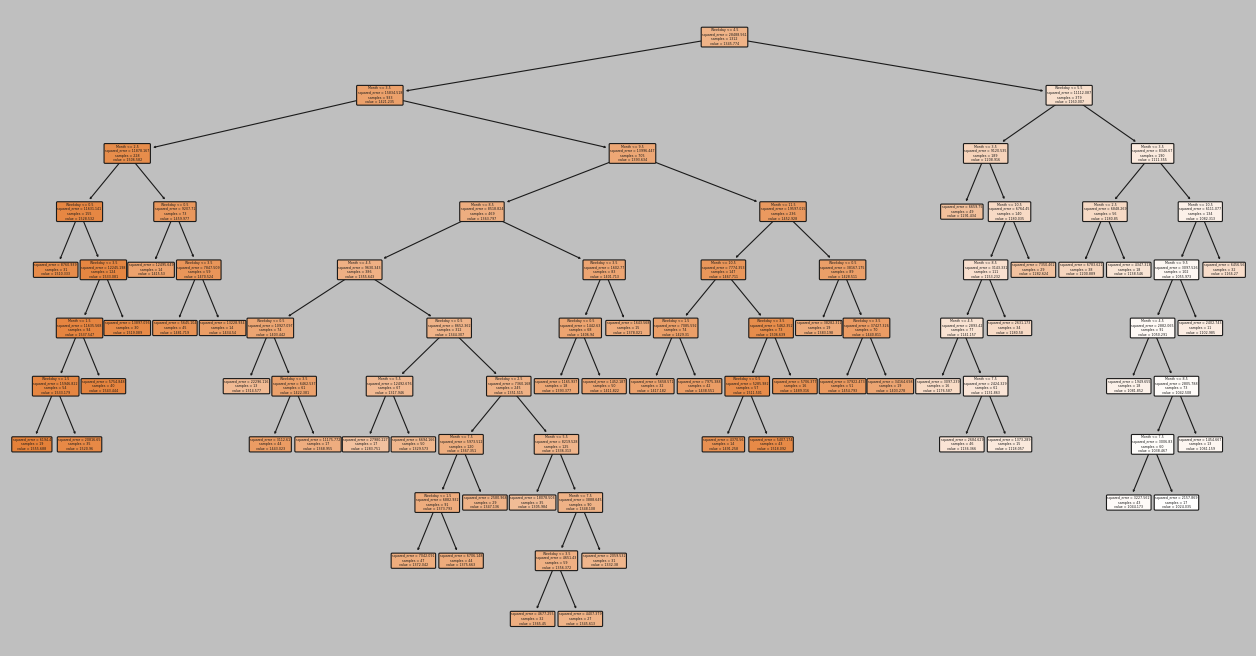

In [43]:
# Trainiere Entescheidungsbaum mit min_samples_split = best_min_split
# best_min_split ist dabei der beste gefundene Wert für diesen Hyperparameter aus der Optimierungs oben.
decision_tree_large = train_decision_tree(X_train, y_train, min_samples_split = best_min_split, output=True)



|--- Weekday <= 4.50
|   |--- Month <= 3.50
|   |   |--- value: [1506.58]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- value: [1363.80]
|   |   |--- Month >  9.50
|   |   |   |--- value: [1452.93]
|--- Weekday >  4.50
|   |--- value: [1160.01]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Mittelwert der wahren Label 1354.86
MAE 78.8784
MSE 10825.0539
MAE% 5.821888109222213
MAPE% 6.066767089328373
RMSE% 7.679288498222414


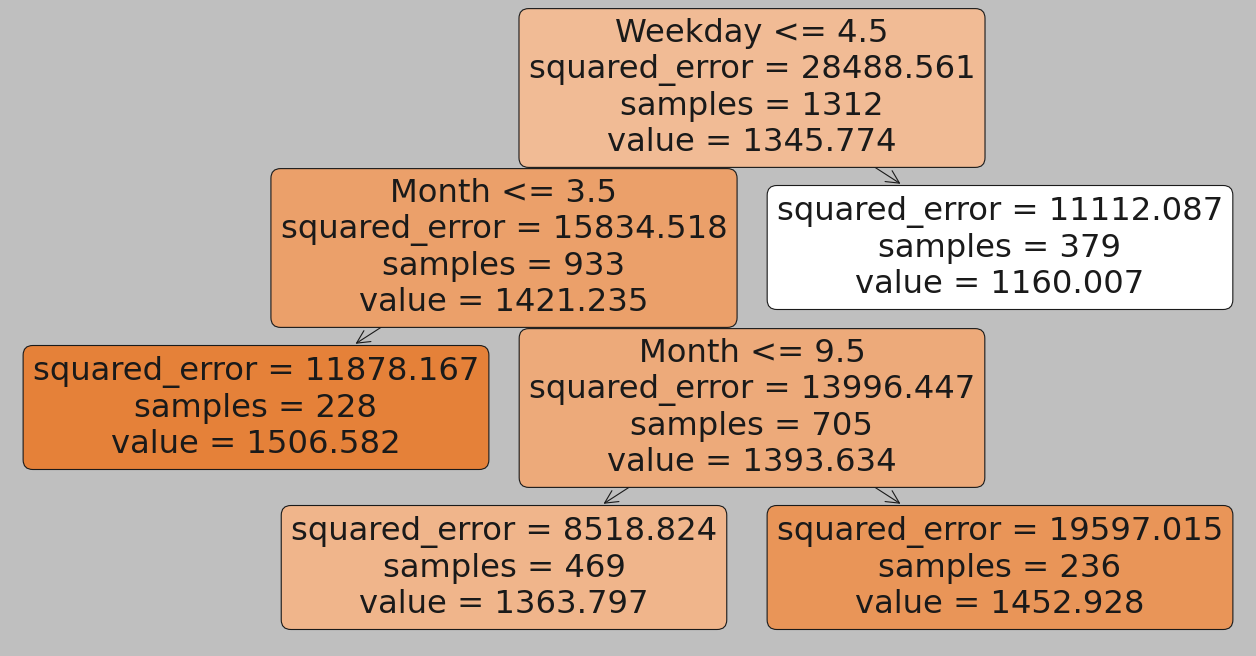

In [91]:
# Trainiere einen kleineren Entscheidungsbaum durch setzen eines anderen Wertes für min_samples_split, sodass mae% vertretbar

# Diese Zeile wieder einkommentieren und anpassen
# Sofern ein MAE von unter 7% 
decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split = 470, output=True) 


# Überprüfe Performance auf Validierungsmenge
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_val, y_val, output=True)

## Aufgabe 12
- Prüfen Sie die Performance des großen und des kleinen Entscheidungsbaumes auf dem Testset.
- Wie interpretieren Sie die Ergebnisse? Wäre der kleine Entscheidungsbaum vertretbar?


Antwort:
Die Abweichungen der relativen Metriken weichen ungefähr um einen Prozent voneinander ab. In Betracht der Komplexität des Großen Entscheidungsbaums ist der kleinere Entscheidungsbaum durchaus vertretbar.
Dadurch, dass der kleine Entscheidungsbaum ein geringes Niveau hat, kann man daraus schließen, dass die 1% der Fehler, die der kleine Entscheidungsbaum ca. mehr macht, durch die Komplexität der unteren Ebenen des großen Entscheidungsbaums verhindert werden können.
Man muss abwiegen, ob die Komplexität die 1% rechtfertigt. 

In [93]:
# Performance des großen Entscheidungsbaums auf dem Testset
print("GROßER ENTSCHEIDUNGSBAUM")
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_test, y_test, output=True)

# Ausgabe einer leeren Zeile für die Übersichtlichkeit
print()

print("KLEINER ENTSCHEIDUNGSBAUM")
# Performance des kleinen Entscheidungsbaums auf dem Testset
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_test, y_test, output=True)


GROßER ENTSCHEIDUNGSBAUM
Mittelwert der wahren Label 1345.42
MAE 62.4499
MSE 7352.7347
MAE% 4.641650291702097
MAPE% 4.778870676763678
RMSE% 6.373313682486634

KLEINER ENTSCHEIDUNGSBAUM
Mittelwert der wahren Label 1345.42
MAE 72.1944
MSE 9303.0237
MAE% 5.365923803578332
MAPE% 5.634047022703434
RMSE% 7.168906422239292


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
